# DCNN Keras Image Classifier

- Author: Felipe Silveira (felipesilveira@ieee.org)
- A simple and generic image classifier (test) built with Keras using cuda libraries.

### Imports

In [1]:
import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
%matplotlib inline

### Adjusting hyperparameters

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress warnings
START_TIME = time.time()

In [4]:
data_dir = "../data/1440/5X/original"
test_data_dir = "../data/1440/5X/test"

In [5]:
results_dir = '../models_checkpoints/'
results_files = os.listdir(results_dir)

In [6]:
results_files

['.gitignore',
 'Xception_tf_0_lr_0.001_batch_16_epochs_2_model.h5',
 'Xception_transfer_learning_weights.h5',
 'Xception_transfer_learning_model.h5',
 'Xception_tf_0_lr_0.001_batch_16_epochs_2_weights.h5']

In [7]:
file_name = 'Xception_tf_0_lr_0.001_batch_16_epochs_2'
file_path = results_dir + file_name

In [8]:
class_names = os.listdir(data_dir)
class_names = [x.title() for x in class_names]
class_names = [x.replace('_',' ') for x in class_names]

In [9]:
img_width, img_height = 256, 256
batch_size = 16

In [10]:
results = {
    "accuracy":"",
    "loss":"",
    "precision":"",
    "recall":"",
    "f1-score":"",
    "report":""
}

In [11]:
def plot_confusion_matrix(confusion_matrix_to_print, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
        This function prints applicationsand plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(confusion_matrix_to_print, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = confusion_matrix_to_print.max() / 2.
    for i, j in itertools.product(range(confusion_matrix_to_print.shape[0]),
                                  range(confusion_matrix_to_print.shape[1])):
        plt.text(j, i, format(confusion_matrix_to_print[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_matrix_to_print[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
def make_confusion_matrix_and_plot(validation_generator, file_name, model_final):
    """Predict and plot confusion matrix"""

    validation_features = model_final.predict_generator(validation_generator,
                                                        validation_generator.samples,
                                                        verbose=1)

    plt.figure(figsize=(10,10))

    plot_confusion_matrix(confusion_matrix(np.argmax(validation_features, axis=1),
                                           validation_generator.classes),
                          classes=class_names,
                          title='Test Confusion Matrix Graph')

    plt.savefig('../output_images/' + file_name + '_matrix_TEST.png')

    print("Total time after generate confusion matrix: %s" %
          (time.time() - START_TIME))

In [13]:
def classification_report_csv(report, file_name):
    """
    This function turns the sklearn report into an array where each class is a position.
    """
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-5]:
        line=" ".join(line.split())
        row = {}
        row_data = line.split(' ')
        #row['class'] = row_data[0]
        row['precision'] = row_data[1]
        row['recall'] = row_data[2]
        row['f1_score'] = row_data[3]
        #row['support'] = row_data[4]
        report_data.append(row)
        
    dataframe = pd.DataFrame.from_dict(report_data)
    print(dataframe)
    
    path = '../results/' + file_name + '_classification_report_TEST.csv'
    dataframe.to_csv(path, index = False)
    print("Report dataframe saved as " + path)
    
    return dataframe

In [14]:
def main():
    
    # used to rescale the pixel values from [0, 255] to [0, 1] interval
    datagen = ImageDataGenerator(rescale=1./255)
    
    test_generator = datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')
    
    # Loading the saved model
    model = load_model(file_path + '_model.h5')
    # Loading weights
    model.load_weights(file_path + '_weights.h5')
    # Printing the model summary
    #model.summary()

    test_predict = model.predict_generator(test_generator, steps=None)
    test_evaluate = model.evaluate_generator(test_generator, test_generator.samples)
    
    # Printing sklearn metrics report for test
    y_true = test_generator.classes
    y_pred = np.argmax(test_predict, axis=1)
    report = metrics.classification_report(y_true, y_pred, digits=6)
    csv_report = classification_report_csv(report, file_name)
    
    # making the confusion matrix of train/test
    test_generator_matrix = datagen.flow_from_directory(
            test_data_dir,
            target_size=(img_width, img_height),
            batch_size=1,
            shuffle=False,
            class_mode='categorical')
    
    make_confusion_matrix_and_plot(
        test_generator_matrix, file_name, model)
    
    # Saving results
    results["accuracy"] = test_evaluate[1]
    results["loss"] = test_evaluate[0]
    results["precision"] = metrics.precision_score(y_true, y_pred, average='macro')
    results["recall"] = metrics.recall_score(y_true, y_pred, average='macro')
    results["f1-score"] = metrics.f1_score(y_true, y_pred, average='macro')
    results["report"] = csv_report
    
    return results

Found 68 images belonging to 17 classes.


/home/silveira/anaconda3/envs/pollen-zoom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


   precision    recall  f1_score
0   0.000000  0.000000  0.000000
1   0.000000  0.000000  0.000000
2   0.000000  0.000000  0.000000
3   0.000000  0.000000  0.000000
4   0.000000  0.000000  0.000000
5   0.000000  0.000000  0.000000
6   0.000000  0.000000  0.000000
7   0.064516  1.000000  0.121212
8   0.000000  0.000000  0.000000
9   0.000000  0.000000  0.000000
10  0.000000  0.000000  0.000000
11  0.000000  0.000000  0.000000
12  0.000000  0.000000  0.000000
13  0.000000  0.000000  0.000000
14  0.000000  0.000000  0.000000
15  0.000000  0.000000  0.000000
16  0.000000  0.000000  0.000000
Report dataframe saved as ../results/Xception_tf_0_lr_0.001_batch_16_epochs_2_classification_report_TEST.csv
Found 68 images belonging to 17 classes.
68/68 [==============================] - 3s 41ms/step
Total time after generate confusion matrix: 34.34205436706543


/home/silveira/anaconda3/envs/pollen-zoom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


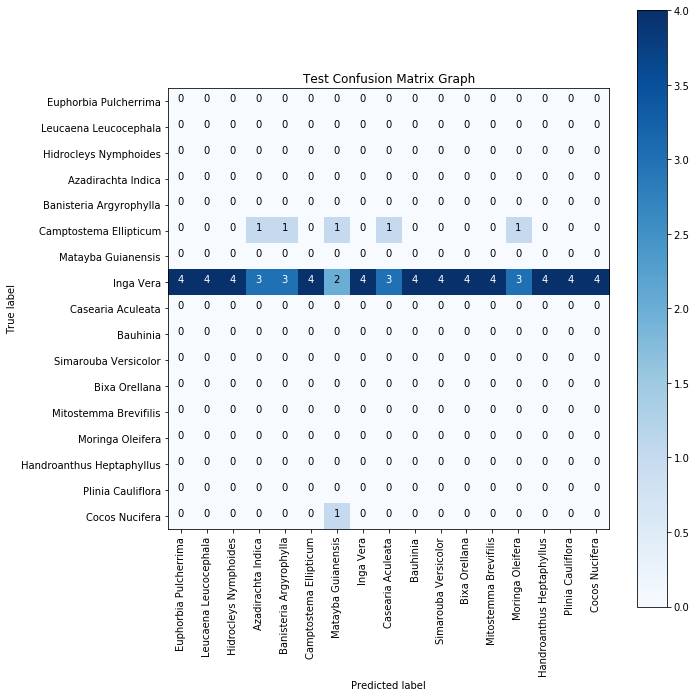

In [15]:
results = main()

In [16]:
results

{'accuracy': 0.06008583679795265,
 'loss': 3.2227725982666016,
 'precision': 0.003795066413662239,
 'recall': 0.058823529411764705,
 'f1-score': 0.007130124777183601,
 'report':    precision    recall  f1_score
 0   0.000000  0.000000  0.000000
 1   0.000000  0.000000  0.000000
 2   0.000000  0.000000  0.000000
 3   0.000000  0.000000  0.000000
 4   0.000000  0.000000  0.000000
 5   0.000000  0.000000  0.000000
 6   0.000000  0.000000  0.000000
 7   0.064516  1.000000  0.121212
 8   0.000000  0.000000  0.000000
 9   0.000000  0.000000  0.000000
 10  0.000000  0.000000  0.000000
 11  0.000000  0.000000  0.000000
 12  0.000000  0.000000  0.000000
 13  0.000000  0.000000  0.000000
 14  0.000000  0.000000  0.000000
 15  0.000000  0.000000  0.000000
 16  0.000000  0.000000  0.000000}